In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install gymnasium

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# التصريح عن صنف المتاهة
class MazeEnv(gym.Env):
    # باني الصنف
    def __init__(self):
        # فضاء الأفعال
        #  0-left, 1-up, 2-right, 3-down
        self.action_space = gym.spaces.Discrete(4)
        # المتاهة
        # 1 = free, 0 = blocked
        self.maze = np.array([
            [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
            [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
            [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
            [0., 0., 1., 0., 0., 1., 0., 1., 1., 1.],
            [1., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
            [1., 1., 0., 1., 0., 1., 1., 1., 1., 1.],
            [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
            [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
            [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
            [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]],dtype=np.float32)
        # قياس المتاهة
        self.size=self.maze.shape[0]
        # فضاء الحالات
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(self.size, self.size) )
        # البداية
        self.start_position = (0, 0)
        # الهدف
        self.goal_position = (self.size - 1, self.size - 1)
        # موضع الوكيل  الحالي
        self.agent_position = self.start_position
        # العدد الأعظمي لحركات الحلقة الواحدة
        self.max_steps = self.size * self.size


    # الحصول على الحالة
    def _get_obs(self):
        # نسخ مصفوفة المتاهة
        obs = np.copy(self.maze)
        x, y = self.agent_position
        # وضع قيمة 0.5 في موضع اللاعب
        obs[x, y] = 0.5
        return obs

    # إعادة التهيئة
    def reset(self, seed=None, options=None):
        # إعادة الوكيل إلى موضع البداية
        self.agent_position = self.start_position
        # الخلايا المزارة سابقاً
        self.visited_cells = set()
        # الوصول إلى الهدف
        self.terminated = False
        # الوصول للحد الأعظمي من الدورات في الحلقة
        self.truncated = False
        # عدد الخطوات التي تمّت
        self.steps = 0
        # إعادة الحالة ومعلوماتها
        return self._get_obs(), {}

    # تنفيذ فعل
    def step(self, action):
        # موضع الوكيل
        x, y = self.agent_position
        # الموقع التالي
        next_x, next_y = x, y

        # تحديث الموضع التالي حسب الفعل
        if action == 0:  # Left
            next_y = max(y - 1, 0)
        elif action == 1:  # Up
            next_x = max(x - 1, 0)
        elif action == 2:  # Right
            next_y = min(y + 1, self.maze.shape[1] - 1)
        elif action == 3:  # Down
            next_x = min(x + 1, self.maze.shape[0] - 1)

        # المكافآت
        if (next_x, next_y) == (x, y):
            reward = -0.8  # لا حركة
        elif self.maze[next_x, next_y] == 0:  # خلية حاجز
            reward = -0.75
        elif (next_x, next_y) in self.visited_cells:  # خلية مزارة سابقاً
            self.agent_position = (next_x, next_y)
            reward = -0.25
        else:
            self.agent_position = (next_x, next_y)
            reward = -0.04 # عقوبة بسيطة للحركة

        # اختبار الوصول للهدف
        if self.agent_position == self.goal_position:
            reward = 100
            self.terminated = True


        # إضافة الموقع الجديد للخلايا المزارة سابقاً
        self.visited_cells.add(self.agent_position)

        # زيادة عداد الخطوات
        self.steps += 1
        # نهاية اللعبة في حال تجاوز العدد الأعظمي لخطوات الحلقة
        if self.steps >= self.max_steps:
            self.truncated = True

        return self._get_obs(), reward, self.terminated, self.truncated, {}


    # التمثيل الرسمي للحالة
    def render(self):
        # إنشاء شكل
        fig, ax = plt.subplots(figsize=(5, 5), dpi=80)
        # عدد الصفوف والأعمدة
        nrows, ncols = self.maze.shape
        # العلامات
        ax.set_xticks(np.arange(0, ncols + 1, 1))
        ax.set_yticks(np.arange(0, nrows + 1, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # إنشاء شبكة
        ax.grid(True, which='both', color='black', linestyle='-', linewidth=2)

        # الخلايا في البداية كلها مستطيلات بيضاء
        for row in range(nrows):
            for col in range(ncols):
                value = self.maze[row, col]
                if value==1:
                  # إضافة مستطيل أبيض
                  ax.add_patch(plt.Rectangle((col, row), 1, 1, color='white'))
                else:
                  ax.add_patch(plt.Rectangle((col, row), 1, 1, color='black'))

        # الخلايا المزارة
        for row, col in self.visited_cells:
            # إضافة مستطيل رمادي
            ax.add_patch(plt.Rectangle((col, row), 1, 1, color='lightgray'))

        agent_x, agent_y = self.agent_position
        # موضع الوكيل باللون الأزرق
        ax.add_patch(plt.Rectangle((agent_y, agent_x), 1, 1, color='blue'))

         # موضع الهدف باللون الأصفر
        goal_x, goal_y = self.goal_position
        ax.add_patch(plt.Rectangle((goal_y, goal_x), 1, 1, color='yellow'))

        # عنوان الرسم
        ax.set_title("Maze Environment")
        # ضبط الرسم
        plt.tight_layout()

        # الرسم
        fig.canvas.draw()
        # الحصول على مصفوفة البكسلات
        img_data = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        # إعادة تشكيل مصفوفة البكسلات
        img_data = img_data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        # إغلاق الرسم
        plt.close(fig)
        return img_data


In [6]:
# دالة تسجيل البيئة
from gymnasium.envs.registration import register

# تسجيل البيئة
register(
    id="CustomMaze-v0",
    entry_point=MazeEnv,
)

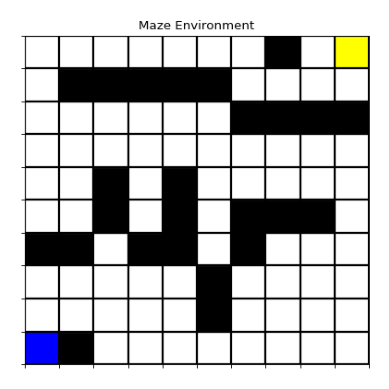

In [7]:
# إنشاء بيئة
env = gym.make("CustomMaze-v0")
# إعادة التهيئة
obs, _ = env.reset()

# الحصول على مصفوفة المتاهة
img_data=env.render()
# رسم الصورة
plt.imshow(img_data)
# إخفاء المحاور
plt.axis('off')
# الإظهار
plt.show()

In [8]:
# قائمة لحفظ الصور المتتالية
frames = []
#  عدد الحلقات
episodes=32
# مكافأت كل الحلقات
episodes_total_reward=0
for episode in range(episodes):
    obs = env.reset()
    frames.append(env.render())
    done = False
    total_reward = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        frames.append(env.render())
        if terminated or truncated:
          done=True
    episodes_total_reward+=total_reward
    print(f"Before Training - Episode {episode + 1} - Total Reward: {total_reward}")
print(f"No training Mean reward: {round(episodes_total_reward/ episodes,2)}")

# إعلاق البيئة
env.close()

Before Training - Episode 1 - Total Reward: -41.76999999999998
Before Training - Episode 2 - Total Reward: -43.230000000000004
Before Training - Episode 3 - Total Reward: -37.519999999999996
Before Training - Episode 4 - Total Reward: -33.77999999999999
Before Training - Episode 5 - Total Reward: -39.709999999999994
Before Training - Episode 6 - Total Reward: -37.599999999999994
Before Training - Episode 7 - Total Reward: -33.760000000000005
Before Training - Episode 8 - Total Reward: -40.31999999999998
Before Training - Episode 9 - Total Reward: -40.24999999999998
Before Training - Episode 10 - Total Reward: -54.64999999999997
Before Training - Episode 11 - Total Reward: -35.51
Before Training - Episode 12 - Total Reward: -38.609999999999985
Before Training - Episode 13 - Total Reward: -34.08999999999999
Before Training - Episode 14 - Total Reward: -35.06999999999999
Before Training - Episode 15 - Total Reward: -45.96999999999997
Before Training - Episode 16 - Total Reward: -44.759999

In [16]:
# مسار مجلد الفيديو
clip_folder='/content/drive/MyDrive/ملفات الاكواد/10. استخدام التعلم المعزز مع مسألة المتاهة/MazeVideos'
# اسم ملف الفيديو
clip_file_name=f"random_Maze.mp4"
# مسار ملف الفيديو
clip_file_path = clip_folder + clip_file_name

In [17]:
# مكتبة التحريك من ماتلاب
import matplotlib.animation as animation

In [11]:
# إعداد غرض للكتابة على فيديو mp4
writer = animation.FFMpegWriter(fps=30)

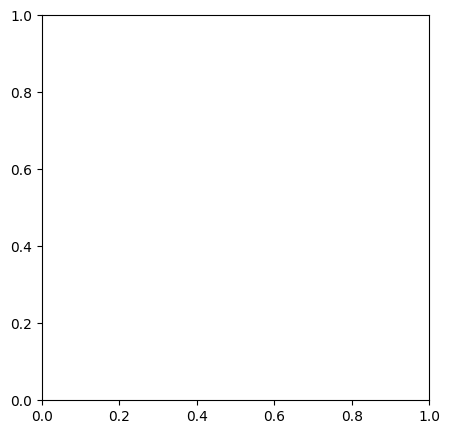

In [18]:
# إنشاء شكل للتحريك
fig, ax = plt.subplots(figsize=(5, 5))

In [19]:
def update_frame(i):
    ax.clear()
    # عرض الإطار i
    ax.imshow(frames[i])
    ax.set_xticks([])
    ax.set_yticks([])

In [20]:
# إنشاء الفيديو
ani = animation.FuncAnimation(fig, update_frame, frames=len(frames))

In [21]:
# الحفظ في ملف
ani.save(clip_file_path, writer=writer)
print("Animation saved ")

Animation saved 


In [22]:
# مكتبة التعلم النوعي
!pip install Simple-Q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for Simple-Q: filename=simple_q-1.0.4-py3-none-any.whl size=6747 sha256=9bd1a9ad58492288c0a995e894f8c6077977214cf45eeddfc108f677e111a917
  Stored in directory: /root/.cache/pip/wheels/c6/9f/2c/d22afa2db9a6238cdc6969f23b8ebf838b43fbf7f3426d626a
Successfully built Simple-Q


In [23]:
# مكتبة التعلم النوعي
from Simple_Q import Qlearning

# عدد الحالات
states = env.observation_space.shape[0] * env.observation_space.shape[1]

In [24]:
# التصريح عن نموذج التعلم النوعي
model = Qlearning(states=states, actions=[0, 1, 2, 3])

In [25]:
# التحويل من حالة إلى فهرس
def state_to_index(state):
    # إيجاد موضع الوكيل
    agent_position = np.argwhere(state == 0.5)

    # صف وعمود موضع الوكيل
    x, y = agent_position[0]

    size = state.shape[0]

    # التحويل لفهرس
    return x * size + y

In [26]:
# عدد حلقات التدريب
train_episodes = 10000
for episode in range(train_episodes):
    # إعادة التهيئة
    state, _ = env.reset()
    # الفهرس
    state_index = state_to_index(state)
    done = False
    total_reward = 0

    while not done:
        # الحصول على الفعل من النموذج
        action = model.get_action(state_index)

        # تطبيق الفعل
        next_state, reward, terminated, truncated , info = env.step(action)

        # فهرس الحالة التالية
        next_state_index = state_to_index(next_state)

        # تحديث جدول القيم النوعية
        model.update_q_table(state_index, action, reward, next_state_index)

        # الانتقال للحالة التالية
        state = next_state
        state_index = next_state_index

        total_reward += reward
        if terminated or truncated:
            done = True
    model.update_epsilon()
    if episode % 10000 == 0:
        print(f"Episode {episode}, Total Reward: {round(total_reward,2)}")


Episode 0, Total Reward: -35.05


In [27]:
# مسار مجلد العمل
working_folder='/content/drive/MyDrive/RLModels/'
# اسم ملف النموذج
filename = 'trained_QL_Model_Maze.pkl'
# مسار ملف النموذج
model_file_path = working_folder + filename

In [28]:
import pickle
with open(model_file_path, 'wb') as f:
  pickle.dump(model, f)
print("model saved to: ", model_file_path)

model saved to:  /content/drive/MyDrive/RLModels/trained_QL_Model_Maze.pkl


In [29]:
# تحميل النموذج
import pickle
with open(model_file_path, 'rb') as f:
  model = pickle.load(f)


In [30]:
# قائمة لحفظ الصور المتتالية
frames = []
#  عدد الحلقات
episodes=4
# مكافأت كل الحلقات
episodes_total_reward=0
for episode in range(episodes):
    state,_ = env.reset()
    state_index = state_to_index(state)
    frames.append(env.render())
    done = False
    total_reward = 0
    while not done:
        action = model.get_action(state_index)
        state, reward, terminated, truncated, info = env.step(action)
        state_index = state_to_index(state)
        total_reward += reward
        frames.append(env.render())
        if terminated or truncated:
          done=True
    episodes_total_reward+=total_reward
    print(f"Before Training - Episode {episode + 1} - Total Reward: {total_reward}")
print(f"After training Mean reward: {round(episodes_total_reward/ episodes,2)}")

# إعلاق البيئة
env.close()

Before Training - Episode 1 - Total Reward: 93.5
Before Training - Episode 2 - Total Reward: 96.14
Before Training - Episode 3 - Total Reward: 96.86
Before Training - Episode 4 - Total Reward: 94.78999999999999
After training Mean reward: 95.32


In [31]:
# مسار مجلد الفيديو
clip_folder='/content/drive/MyDrive/ملفات الاكواد/10. استخدام التعلم المعزز مع مسألة المتاهة/MazeVideos'
# اسم ملف الفيديو
clip_file_name=f"trained_QL_Maze.mp4"
# مسار ملف الفيديو
clip_file_path = clip_folder + clip_file_name

In [32]:
# إعداد غرض للكتابة على فيديو mp4
writer = animation.FFMpegWriter(fps=30)

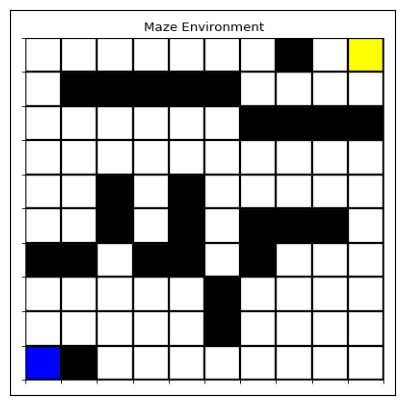

In [33]:
# إنشاء شكل للتحريك
fig, ax = plt.subplots(figsize=(5, 5))
# إنشاء الفيديو
ani = animation.FuncAnimation(fig, update_frame, frames=len(frames))

In [34]:
# الحفظ في ملف
ani.save(clip_file_path, writer=writer)
print("Animation saved ")

Animation saved 
